## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
ann_backdoors.pkl	OTset.csv		    testset.csv
ann_dos.pkl		preprocessing.csv	    UNSW-NB15_1.csv
ann_shellcode.pkl	preprosessing-dos.csv	    UNSW-NB15_2.csv
encoded-data.csv	RandomForrest_Analysis.pkl  UNSW-NB15_3.csv
knn_worms.pkl		selected_columns_all.csv    UNSW-NB15_4.csv
NUSW-NB15_features.csv	SVR-predict-data.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
col=list(select_col['Fuzzers'])


#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


Exploits_attacks = df[df['Fuzzers'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [Exploits_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Fuzzers']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[col],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[0.00000000e+00, 2.54000000e-06, 6.00000000e-08, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.03794818e-02, 4.06999539e-02, 8.01180194e-04, ...,
        1.09280979e-01, 9.13345421e-03, 9.86053541e-01],
       [0.00000000e+00, 5.11363660e-07, 5.11363660e-08, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.05176437e-03, 1.12429985e-03, 1.81338685e-04, ...,
        3.20026512e-01, 2.66567867e-02, 4.77393285e-01],
       [4.54656365e-05, 4.86011976e-05, 3.13556114e-06, ...,
        5.01689782e-04, 1.25422446e-04, 9.99999331e-01],
       [4.14990749e-06, 4.43610801e-06, 7.15501292e-07, ...,
        3.51454235e-04, 1.94616351e-05, 9.99789131e-01]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [5]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Fuzzers'])

test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

Exploits_attacks  = test_data[test_data['attack_cat'] == 'Fuzzers']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [Exploits_attacks , Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#**Random Forrest Regression**

In [9]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.075510,0.001980,0.001510,0.000077,True,2,auto,1,2,2,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.825012,0.819523,0.804024,0.813124,0.826772,0.817691,0.008331,205
1,0.146131,0.003421,0.001927,0.000148,True,2,auto,1,2,4,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.825115,0.819793,0.803988,0.813339,0.826731,0.817793,0.008342,193
2,0.292610,0.006454,0.002724,0.000209,True,2,auto,1,2,8,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.825079,0.819675,0.804094,0.813102,0.826782,0.817746,0.008332,199
3,0.568627,0.008607,0.004106,0.000361,True,2,auto,1,2,16,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.825124,0.819795,0.804095,0.813285,0.826867,0.817833,0.008343,169
4,1.187483,0.108732,0.007264,0.000277,True,2,auto,1,2,32,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.825114,0.819711,0.804107,0.813219,0.826848,0.817800,0.008337,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.186758,0.006431,0.002906,0.000106,False,4,sqrt,2,5,8,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.841520,0.837013,0.821213,0.829215,0.842664,0.834325,0.008082,94
332,0.364805,0.006987,0.004806,0.000215,False,4,sqrt,2,5,16,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.831759,0.828016,0.810325,0.821509,0.833369,0.824995,0.008395,154
333,0.712486,0.010073,0.008527,0.000265,False,4,sqrt,2,5,32,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.835683,0.830491,0.811468,0.825259,0.836437,0.827867,0.009134,136
334,1.470193,0.111985,0.015871,0.000725,False,4,sqrt,2,5,64,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.836011,0.831684,0.813888,0.825485,0.838091,0.829032,0.008715,117


In [10]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.817691
1,True,2,auto,1,2,4,0.817793
2,True,2,auto,1,2,8,0.817746
3,True,2,auto,1,2,16,0.817833
4,True,2,auto,1,2,32,0.817800
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.834325
332,False,4,sqrt,2,5,16,0.824995
333,False,4,sqrt,2,5,32,0.827867
334,False,4,sqrt,2,5,64,0.829032


In [11]:
regressor.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 16}

**Train the model**

In [12]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(random_state=0,bootstrap=True,max_depth=4,max_features= 'auto',min_samples_leaf=2,min_samples_split=2,n_estimators=16)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-12-547039935729>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [13]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.942112
Accuracy when threshould =  0.02 0.942965
Accuracy when threshould =  0.03 0.943102
Accuracy when threshould =  0.04 0.943204
Accuracy when threshould =  0.05 0.943238
Accuracy when threshould =  0.06 0.943238
Accuracy when threshould =  0.07 0.943273
Accuracy when threshould =  0.08 0.943273
Accuracy when threshould =  0.09 0.943273
Accuracy when threshould =  0.1 0.943273
Accuracy when threshould =  0.11 0.943273
Accuracy when threshould =  0.12 0.943273
Accuracy when threshould =  0.13 0.943273
Accuracy when threshould =  0.14 0.943273
Accuracy when threshould =  0.15 0.943273
Accuracy when threshould =  0.16 0.943307
Accuracy when threshould =  0.17 0.943341
Accuracy when threshould =  0.18 0.943341
Accuracy when threshould =  0.19 0.943341
Accuracy when threshould =  0.2 0.943341
Accuracy when threshould =  0.21 0.943341
Accuracy when threshould =  0.22 0.943375
Accuracy when threshould =  0.23 0.943375
Accuracy when threshould =  0.24 0.9

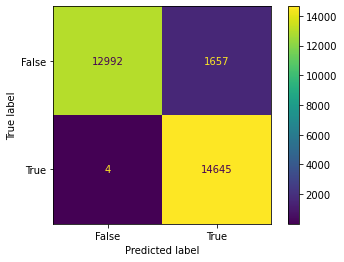

In [14]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

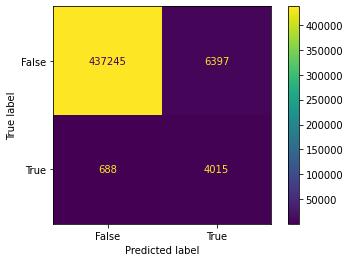

Accuracy when threshould =  0.8 0.984197


In [15]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.8


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))

#**Save the model**

In [18]:
from joblib import Parallel, delayed
import joblib
from sklearn.ensemble import RandomForestRegressor


#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(random_state=0,bootstrap=True,max_depth=4,max_features= 'auto',min_samples_leaf=2,min_samples_split=2,n_estimators=16)

# fit the regressor with x and y data
regressor.fit(x, y)

# Save the model as a pickle in a file
joblib.dump(regressor, 'RandomForrest_Fuzzer.pkl')

# Load the model from the file
RF_from_joblib = joblib.load('RandomForrest_Fuzzer.pkl')

# Use the loaded model to make predictions
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = RF_from_joblib.predict(x_test_array)

<ipython-input-18-8ed357ebbfb0>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


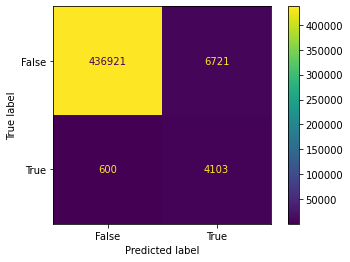

Accuracy when threshould =  0.6 0.983671


In [19]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import accuracy_score

threshould =0.6


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))